# State SARS-Cov-2 WVAL and COVID-19 Cases Comparison
This notebook compares Wastewater Viral Activity Levels (WVALs) for SARS-CoV-2 (SC2) with COVID-19 Cases from publicly available data.
This is intended as a template for users who wish to perform their own analyses on the new WVAL metric.

## Imports

In [127]:
import pandas as pd 
import numpy as np 

Importing the public cases dataset (Weekly United States COVID-19 Cases and Deaths by State - ARCHIVED) from [data.cdc.gov](https://data.cdc.gov/Case-Surveillance/Weekly-United-States-COVID-19-Cases-and-Deaths-by-/pwn4-m3yp/about_data)

We'll use the code from the API documentation for data.cdc.gov.

In [157]:
# %pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [158]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

results = client.get("pwn4-m3yp", limit=12000)

# Convert to pandas DataFrame
cases_df = pd.DataFrame.from_records(results)

cases_df.head()

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,2023-02-23T00:00:00.000,AZ,2023-02-16T00:00:00.000,2023-02-22T00:00:00.000,2434631.0,3716.0,33042.0,39.0,23150,0
1,2022-12-22T00:00:00.000,LA,2022-12-15T00:00:00.000,2022-12-21T00:00:00.000,1507707.0,4041.0,18345.0,21.0,21397,0
2,2023-02-23T00:00:00.000,GA,2023-02-16T00:00:00.000,2023-02-22T00:00:00.000,3061141.0,5298.0,42324.0,88.0,6800,0
3,2023-03-30T00:00:00.000,LA,2023-03-23T00:00:00.000,2023-03-29T00:00:00.000,1588259.0,2203.0,18858.0,23.0,5347,0
4,2023-02-02T00:00:00.000,LA,2023-01-26T00:00:00.000,2023-02-01T00:00:00.000,1548508.0,5725.0,18572.0,47.0,4507,0


In [159]:
len(cases_df)

10380

Importing the state WVAL data shown on the [State and Territory Trends Dashboard](https://www.cdc.gov/nwss/rv/COVID19-statetrend.html).

In [160]:
import requests

# URL for the JSON data
url = "https://www.cdc.gov/wcms/vizdata/NCEZID_DIDRI/NWSSStateLevel.json"

# Making a request to the URL
response = requests.get(url)

# Decoding the content with 'utf-8-sig' to handle BOM
content = response.content.decode('utf-8-sig')
data = json.loads(content)

# Converting the JSON data to a pandas dataframe
wval_df = pd.json_normalize(data)

# Display the first few rows of the dataframe
wval_df.head()


,date,date_period,State,value,national_value,region_value
0,2022-01-01,All Results,Michigan,14.305279825535322,17.912300475962088,20.688484818204877
1,2022-01-01,All Results,Illinois,11.497446593582922,17.912300475962088,20.688484818204877
2,2022-01-01,All Results,Idaho,23.495124167551566,17.912300475962088,13.931172026548118
3,2022-01-01,All Results,Utah,13.899477807619023,17.912300475962088,13.931172026548118
4,2022-01-01,All Results,Virginia,16.491607944469514,17.912300475962088,16.54269541744756


## Cleaning

First, we need to see if the two datasets are using the same week cadence for their aggregation.

In [161]:
# convert the cases dates to a date format
cases_df['end_date'] = pd.to_datetime(cases_df['end_date'])
cases_df['end_date'] = cases_df['end_date'].apply(lambda x: x.date() if pd.notnull(x) else None)

# make a copy of cases_df before date filtering for subsequent use
cases_copy = cases_df.copy()

# the cases dataset starts much earlier than the wval dataset, so we filter to get dates in same range
start_date = pd.to_datetime('2022-01-01').date()
cases_df = cases_df[cases_df.end_date >= start_date]

# First check the end_dates for the cases dataset
unique_end_dates = cases_df['end_date'].dropna().unique()
sorted_unique_end_dates = sorted(unique_end_dates)[:5]
sorted_unique_end_dates

[datetime.date(2022, 1, 5),
 datetime.date(2022, 1, 12),
 datetime.date(2022, 1, 19),
 datetime.date(2022, 1, 26),
 datetime.date(2022, 2, 2)]

In [162]:
# convert the wval dates to a date format
wval_df['date'] = pd.to_datetime(wval_df['date'])
wval_df['date'] = wval_df['date'].apply(lambda x: x.date() if pd.notnull(x) else None)
# Next check the dates (equivalent to end date) for the WVALs dataset
unique_end_dates = wval_df['date'].dropna().unique()
sorted_unique_end_dates = sorted(unique_end_dates)
sorted_unique_end_dates[:5]

[datetime.date(2022, 1, 1),
 datetime.date(2022, 1, 8),
 datetime.date(2022, 1, 15),
 datetime.date(2022, 1, 22),
 datetime.date(2022, 1, 29)]

The datasets are out of sync, so we will have to address this.
The cases dataset is on a *Thursday to Wednesday* week.
The wval dataset is on a *Sunday to Saturday* week.

We will effect a crude solution by simply adding days to the end_dates for the wval dataset.
Given that changes wastewater data have been seen to precede case data changes, this solution is preferable to the reverse.

In [163]:
from datetime import timedelta

# This function assumes 'date' is a datetime.date object
def align_dates(date):
    # Find the weekday number, with Monday as 0 and Sunday as 6
    weekday = date.weekday()
    
    # If the date is from Sunday (6) to Wednesday (2), add the necessary days
    # to align it to the following Wednesday
    if weekday < 3:  # From Sunday to Wednesday
        # Add the difference to reach the next Wednesday
        return date + timedelta(days=(2 - weekday))
    elif weekday > 3:  # From Thursday to Saturday
        # Add the days needed to reach the next Wednesday
        return date + timedelta(days=(9 - weekday))
    else:  # If it's already Wednesday, no change needed
        return date

# Apply the function to the 'end_date' column of the wval_df dataframe
wval_df['aligned_end_date'] = wval_df['date'].apply(align_dates)


Now, we'll compare dates again to see if this worked.

In [164]:
# First check the end_dates for the cases dataset
unique_end_dates = cases_df['end_date'].dropna().unique()
sorted_unique_end_dates = sorted(unique_end_dates)[:3]
sorted_unique_end_dates

[datetime.date(2022, 1, 5),
 datetime.date(2022, 1, 12),
 datetime.date(2022, 1, 19)]

In [165]:
# Next check the dates (equivalent to end date) for the WVALs dataset
unique_end_dates = wval_df['aligned_end_date'].dropna().unique()
sorted_unique_end_dates = sorted(unique_end_dates)
sorted_unique_end_dates[:3]

[datetime.date(2022, 1, 5),
 datetime.date(2022, 1, 12),
 datetime.date(2022, 1, 19)]

This shows the date cadence is now aligned between the datasets.

In [166]:
# the wval dataset includes multiple versions of the data for each timeframe, we'll filter to only the "All results" date_period
wval_df = wval_df[wval_df.date_period == 'All Results']
# select desired cols from the wval df
wval_cols = ['aligned_end_date', 'State', 'value']
wval_df = wval_df[wval_cols].rename(columns={"value":"wval", "aligned_end_date":"end_date"})
wval_df.head()

,end_date,State,wval
0,2022-01-05,Michigan,14.305279825535322
1,2022-01-05,Illinois,11.497446593582922
2,2022-01-05,Idaho,23.495124167551566
3,2022-01-05,Utah,13.899477807619023
4,2022-01-05,Virginia,16.491607944469514


In [167]:
# select desired cases cols
cases_cols = ['end_date', 'state', 'new_cases']
cases_df = cases_df[cases_cols]
cases_df.head()

,end_date,state,new_cases
0,2023-02-22,AZ,3716.0
1,2022-12-21,LA,4041.0
2,2023-02-22,GA,5298.0
3,2023-03-29,LA,2203.0
4,2023-02-01,LA,5725.0


The last step to preparing the cases data is to convert the state abbreviations to state names to match the WVAL data.

In [168]:
# only run this once
# %pip install us

In [169]:
import us

print(f'length before merge: {len(cases_df)}')

# Create a list of dictionaries, each containing a state's name and abbreviation
states = [{'State': state.name, 'abbrev': state.abbr} for state in us.states.STATES_AND_TERRITORIES]

# Convert the list of dictionaries into a DataFrame
abbrevs = pd.DataFrame(states)

# join to cases dataset, then drop abbreiviation columns
cases_df = cases_df.merge(abbrevs, left_on='state', right_on='abbrev', how='left').drop(columns=['state','abbrev'])

print(f'length after merge: {len(cases_df)}')
print(cases_df.head())

length before merge: 4260
length after merge: 4260
     end_date new_cases      State
0  2023-02-22    3716.0    Arizona
1  2022-12-21    4041.0  Louisiana
2  2023-02-22    5298.0    Georgia
3  2023-03-29    2203.0  Louisiana
4  2023-02-01    5725.0  Louisiana


### Merge datasets and filter dates.
The wval dataset begins in Jan 2022 and the cases dataset stops being updated as of June 2023, lets see how our data match up in that timeframe.

In [170]:
print(f'The cases dataset goes from {cases_df.end_date.min()} to {cases_df.end_date.max()}')
print(f'The wval dataset goes from {wval_df.end_date.min()} to {wval_df.end_date.max()}')

The cases dataset goes from 2022-01-05 to 2023-05-10
The wval dataset goes from 2022-01-05 to 2023-12-06


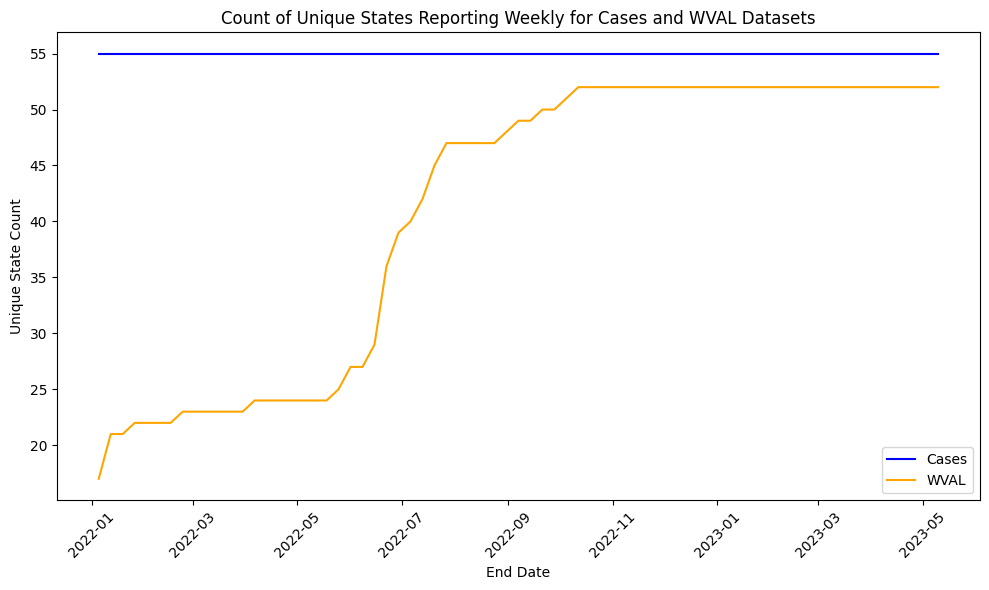

In [171]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming cases_df and wval_df are your dataframes and they are already loaded with 'end_date' in datetime format.

# Clip wval_df to match the cases_df timeframe
end_date = pd.to_datetime('2023-05-10').date()
wval_df = wval_df[wval_df['end_date'] <= end_date]

# Group by 'end_date' and count unique 'state' values for each dataset
cases_grouped = cases_df.groupby('end_date')['State'].nunique()
wval_grouped = wval_df.groupby('end_date')['State'].nunique()

# Create a line plot
plt.figure(figsize=(10, 6))

plt.plot(cases_grouped.index, cases_grouped.values, label='Cases', color='blue')
plt.plot(wval_grouped.index, wval_grouped.values, label='WVAL', color='orange')

# Adding title and labels
plt.title('Count of Unique States Reporting Weekly for Cases and WVAL Datasets')
plt.xlabel('End Date')
plt.ylabel('Unique State Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend to distinguish the two lines
plt.legend()

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


In [175]:
# merge data
wval_cases = pd.merge(wval_df, cases_df, left_on=['end_date','State'],right_on=['end_date','State'], how='left')

wval_cases.head(5)

,end_date,State,wval,new_cases
0,2022-01-05,Michigan,14.305279825535322,98413.0
1,2022-01-05,Illinois,11.497446593582922,176283.0
2,2022-01-05,Idaho,23.495124167551566,5507.0
3,2022-01-05,Utah,13.899477807619023,29982.0
4,2022-01-05,Virginia,16.491607944469514,99482.0


## Test Correlations

Now that the data is prepared, we are ready to test correlations.
First, let's start by displaying this as a distribution of the Spearman Rank correlation scores by state.

array([[<Axes: title={'center': 'spearman_correlation'}>]], dtype=object)

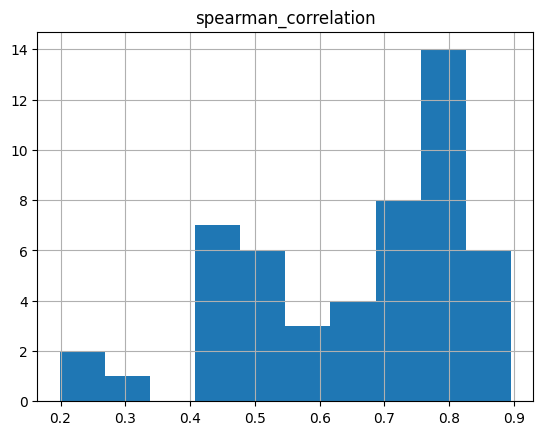

In [178]:
# Define a function to calculate Spearman correlation for a group
def calculate_spearman_correlation(group):
    correlation = group['wval'].corr(group['new_cases'], method='spearman')
    return pd.DataFrame({'state': [group.name], 'spearman_correlation': [round(correlation,3)]})

# Group the data by 'state' and apply the correlation calculation
state_correlations = wval_cases.groupby('State').apply(calculate_spearman_correlation).reset_index(drop=True)

state_correlations = state_correlations.sort_values('spearman_correlation').dropna()
state_correlations.hist()